In [1]:
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns
import pandas as pd
from functools import reduce
#pip install getFamaFrenchFactors
import getFamaFrenchFactors as gff
#pip install fredapi
from fredapi import Fred
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm

### Fama French

In [2]:
data_ff5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows=3)

In [3]:
data_ff5.rename(columns = {'Unnamed: 0':'Date'},inplace=True)

In [4]:
data_ff5['Date']=data_ff5['Date'].apply(str)


In [5]:
data_ff5.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012


In [6]:
data_ff5.reset_index(drop = True, inplace= True)
data_ff5 = data_ff5[(data_ff5.Date > '20200101') & (data_ff5.Date <= '20231231')]
data_ff5['Date']=pd.to_datetime(data_ff5['Date'])
data_ff5

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
14223,2020-01-02,0.86,-0.97,-0.34,0.24,-0.22,0.006
14224,2020-01-03,-0.67,0.30,0.00,-0.14,-0.10,0.006
14225,2020-01-06,0.36,-0.20,-0.55,-0.17,-0.26,0.006
14226,2020-01-07,-0.19,-0.03,-0.25,-0.12,-0.25,0.006
14227,2020-01-08,0.47,-0.17,-0.64,-0.19,-0.17,0.006
...,...,...,...,...,...,...,...
15183,2023-10-25,-1.58,-0.02,0.84,1.50,0.20,0.021
15184,2023-10-26,-1.15,1.19,1.66,-0.76,0.48,0.021
15185,2023-10-27,-0.53,-0.58,-0.57,0.42,-0.96,0.021
15186,2023-10-30,1.15,-0.34,0.28,-0.14,0.17,0.021


In [7]:
df_ffs = data_ff5.set_index('Date')

In [8]:
df_ffs

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2020-01-02,0.86,-0.97,-0.34,0.24,-0.22,0.006
2020-01-03,-0.67,0.30,0.00,-0.14,-0.10,0.006
2020-01-06,0.36,-0.20,-0.55,-0.17,-0.26,0.006
2020-01-07,-0.19,-0.03,-0.25,-0.12,-0.25,0.006
2020-01-08,0.47,-0.17,-0.64,-0.19,-0.17,0.006
...,...,...,...,...,...,...
2023-10-25,-1.58,-0.02,0.84,1.50,0.20,0.021
2023-10-26,-1.15,1.19,1.66,-0.76,0.48,0.021
2023-10-27,-0.53,-0.58,-0.57,0.42,-0.96,0.021


### ADS Index

In [9]:
data_ads = pd.read_excel('ADS Index Most Current Vintage.xlsx')

In [10]:
data_ads

,Unnamed: 0,ADS_Index
0,1960:03:01,-0.572930
1,1960:03:02,-0.621487
2,1960:03:03,-0.666982
3,1960:03:04,-0.709432
4,1960:03:05,-0.748855
...,...,...
23282,2023:11:28,-0.147276
23283,2023:11:29,-0.143545
23284,2023:11:30,-0.140216
23285,2023:12:01,-0.137288


In [11]:
data_ads.rename(columns = {'Unnamed: 0':'Date'},inplace=True)

In [12]:
data_ads['Date'] = data_ads['Date'].str.replace(':', '-')

In [13]:
data_ads = data_ads[(data_ads.Date > '2020-01-01') & (data_ads.Date <= '2023-12-31')]

In [14]:
data_ads['Date'] = pd.to_datetime(data_ads['Date'])

In [15]:
df_ads = data_ads.set_index('Date')

In [16]:
df_ads

,ADS_Index
Date,
2020-01-02,-0.308743
2020-01-03,-0.292342
2020-01-04,-0.276362
2020-01-05,-0.260796
2020-01-06,-0.245729
...,...
2023-11-28,-0.147276
2023-11-29,-0.143545
2023-11-30,-0.140216


### Fred

In [17]:
fred = Fred(api_key='6fff19c7fff2c26131d75747d34452d6')

In [18]:
fred

In [19]:
varList = ['AMERIBOR', 'T10YIE', 'T5YIE', 'RSXFS','UNRATE', 
               'DGS10', 'DGS1', 'WPU072', 'DCPN3M', 'DCPF1M', 'DCOILWTICO', 
               'DHHNGSP']

In [20]:
SP500 = fred.get_series('SP500')
SP500.name = 'SP500'
df_fred = SP500

In [21]:
df_fred

2013-12-12    1775.50
2013-12-13    1775.32
2013-12-16    1786.54
2013-12-17    1781.00
2013-12-18    1810.65
               ...   
2023-12-05    4567.18
2023-12-06    4549.34
2023-12-07    4585.59
2023-12-08    4604.37
2023-12-11    4622.44
Name: SP500, Length: 2608, dtype: float64

In [22]:
# merge data series
for i in range(0, len(varList)):
    data = fred.get_series(varList[i])
    data.name = varList[i]
    df_fred = pd.merge(df_fred, data, left_index=True, right_index=True)

In [23]:
df_fred

,SP500,AMERIBOR,T10YIE,T5YIE,RSXFS,UNRATE,DGS10,DGS1,WPU072,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP
2016-01-01,NaN,NaN,NaN,NaN,394486.0,4.8,NaN,NaN,196.000,NaN,NaN,NaN,2.28
2016-02-01,1939.38,0.53000,1.40,1.20,397676.0,4.9,1.97,0.47,195.600,0.47,0.40,31.62,2.28
2016-03-01,1978.35,0.52000,1.48,1.29,396630.0,5.0,1.83,0.68,195.400,0.48,0.40,34.39,1.57
2016-04-01,2072.78,0.56286,1.62,1.49,398199.0,5.1,1.79,0.62,195.700,0.48,0.39,35.36,1.88
2016-06-01,2099.33,0.56767,1.54,1.47,404475.0,4.9,1.85,0.70,196.100,NaN,0.43,49.07,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,3951.39,4.86584,2.44,2.59,594281.0,3.5,4.01,5.06,275.304,4.79,4.66,77.57,2.59
2023-05-01,4167.87,5.10960,2.23,2.24,599958.0,3.7,3.59,4.86,275.061,NaN,5.02,75.65,2.24
2023-06-01,4221.02,5.26738,2.16,2.07,600736.0,3.6,3.61,5.11,273.420,NaN,NaN,70.09,1.77
2023-08-01,4576.73,5.50198,2.37,2.26,608386.0,3.8,4.05,5.38,271.922,NaN,5.35,81.37,2.49


### Merging Data

In [24]:
DATA_part1 = pd.merge(df_ffs, df_ads, left_index=True, right_index=True)

In [25]:
DATA = pd.merge(DATA_part1, df_fred,left_index=True, right_index=True,how='inner')

In [26]:
DATA.reset_index(inplace=True)
DATA = DATA.rename(columns = {'index':'Date'})

In [27]:
DATA

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,SP500,AMERIBOR,...,T5YIE,RSXFS,UNRATE,DGS10,DGS1,WPU072,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP
0,2020-04-01,-4.51,-1.99,-1.40,0.22,0.22,0.000,-25.353600,2470.50,0.165341,...,0.56,376992.0,14.7,0.62,0.16,207.200,2.05,NaN,20.28,1.69
1,2020-05-01,-2.91,-0.90,-0.97,-0.36,0.35,0.000,-10.982500,2830.71,0.150777,...,0.68,444746.0,13.2,0.64,0.17,206.800,0.21,NaN,19.72,1.69
2,2020-06-01,0.52,0.26,0.43,-0.01,-0.14,0.000,8.992070,3055.73,0.114417,...,0.84,474621.0,11.0,0.66,0.17,206.300,0.24,NaN,35.49,1.59
3,2020-07-01,0.41,-1.71,-2.58,-0.42,-1.22,0.001,7.432020,3115.86,0.095443,...,1.17,480461.0,10.2,0.69,0.16,205.900,0.13,0.13,39.88,1.69
4,2020-09-01,0.92,0.19,-0.30,0.61,0.14,0.000,2.039570,3526.65,0.101483,...,1.65,492411.0,7.9,0.68,0.12,206.400,0.10,NaN,42.76,2.22
5,2020-10-01,0.79,0.79,-0.54,-0.02,-0.58,0.000,1.081160,3380.80,0.096466,...,1.48,490482.0,6.9,0.68,0.12,207.400,0.12,0.11,38.51,1.60
6,2020-12-01,0.98,-0.08,0.53,1.07,0.49,0.000,-0.105370,3662.45,0.076951,...,1.72,496423.0,6.7,0.92,0.12,208.700,0.12,0.15,44.54,2.89
7,2021-02-01,1.73,0.74,-1.47,-0.23,-1.22,0.000,-0.716711,3773.86,0.070771,...,2.18,497758.0,6.2,1.09,0.08,212.300,0.09,0.08,53.55,2.88
8,2021-03-01,2.63,1.11,0.23,-0.41,0.23,0.000,0.052408,3901.82,0.090659,...,2.40,550349.0,6.1,1.45,0.08,216.700,0.07,0.07,60.54,2.70
9,2021-04-01,1.27,0.21,0.00,-0.68,-0.51,0.000,1.634780,4019.87,0.092291,...,2.55,552575.0,6.1,1.69,0.06,223.800,0.10,0.07,61.41,2.52


### Collecting Lululemon stocks form yfinance

In [28]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,12,31)

LULU = yf.download('LULU',start_date ,end_date)
LULU.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [29]:
LULU

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,232.899994,233.470001,231.770004,233.419998,233.419998,1449300
1,2020-01-03,231.240005,234.500000,230.229996,232.639999,232.639999,1315400
2,2020-01-06,231.490005,235.529999,230.800003,235.429993,235.429993,1460700
3,2020-01-07,235.500000,236.850006,233.339996,233.699997,233.699997,1367900
4,2020-01-08,234.880005,238.009995,234.009995,237.270004,237.270004,1883900
...,...,...,...,...,...,...,...
989,2023-12-06,459.279999,464.059998,458.269989,460.670013,460.670013,1387200
990,2023-12-07,460.670013,466.630005,460.600006,464.670013,464.670013,3243500
991,2023-12-08,455.880005,493.799988,448.809998,489.640015,489.640015,7136900
992,2023-12-11,493.950012,507.440002,490.000000,502.739990,502.739990,2799000


In [30]:
LULU_new = pd.merge(LULU, DATA,on = 'Date',how='inner')

In [31]:
LULU_new

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,T5YIE,RSXFS,UNRATE,DGS10,DGS1,WPU072,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP
0,2020-04-01,181.529999,187.279999,181.529999,183.500000,183.500000,1767800,-4.51,-1.99,-1.40,...,0.56,376992.0,14.7,0.62,0.16,207.200,2.05,NaN,20.28,1.69
1,2020-05-01,219.110001,220.460007,216.199997,218.690002,218.690002,1744600,-2.91,-0.90,-0.97,...,0.68,444746.0,13.2,0.64,0.17,206.800,0.21,NaN,19.72,1.69
2,2020-06-01,299.769989,310.220001,297.250000,308.690002,308.690002,2390200,0.52,0.26,0.43,...,0.84,474621.0,11.0,0.66,0.17,206.300,0.24,NaN,35.49,1.59
3,2020-07-01,314.500000,316.989990,306.359985,308.619995,308.619995,1767500,0.41,-1.71,-2.58,...,1.17,480461.0,10.2,0.69,0.16,205.900,0.13,0.13,39.88,1.69
4,2020-09-01,376.600006,391.380005,373.559998,391.160004,391.160004,1363100,0.92,0.19,-0.30,...,1.65,492411.0,7.9,0.68,0.12,206.400,0.10,NaN,42.76,2.22
5,2020-10-01,334.010010,343.269989,332.619995,341.049988,341.049988,1715900,0.79,0.79,-0.54,...,1.48,490482.0,6.9,0.68,0.12,207.400,0.12,0.11,38.51,1.60
6,2020-12-01,373.209991,379.690002,370.440002,377.519989,377.519989,1510600,0.98,-0.08,0.53,...,1.72,496423.0,6.7,0.92,0.12,208.700,0.12,0.15,44.54,2.89
7,2021-02-01,329.380005,334.220001,324.399994,333.470001,333.470001,1410700,1.73,0.74,-1.47,...,2.18,497758.0,6.2,1.09,0.08,212.300,0.09,0.08,53.55,2.88
8,2021-03-01,313.089996,317.350006,312.109985,314.829987,314.829987,1315000,2.63,1.11,0.23,...,2.40,550349.0,6.1,1.45,0.08,216.700,0.07,0.07,60.54,2.70
9,2021-04-01,308.290009,308.790009,300.320007,301.070007,301.070007,2987500,1.27,0.21,0.00,...,2.55,552575.0,6.1,1.69,0.06,223.800,0.10,0.07,61.41,2.52


In [32]:
# Yesterday's Close Price
LULU_new['Yest_Close']  = LULU_new['Adj Close'].shift(1)

In [33]:
# Tesla Stock Returns
LULU_new['stock_return'] = (LULU_new['Adj Close']-LULU_new['Yest_Close'])/(LULU_new['Yest_Close'])

In [34]:
LULU_new

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,UNRATE,DGS10,DGS1,WPU072,DCPN3M,DCPF1M,DCOILWTICO,DHHNGSP,Yest_Close,stock_return
0,2020-04-01,181.529999,187.279999,181.529999,183.500000,183.500000,1767800,-4.51,-1.99,-1.40,...,14.7,0.62,0.16,207.200,2.05,NaN,20.28,1.69,NaN,NaN
1,2020-05-01,219.110001,220.460007,216.199997,218.690002,218.690002,1744600,-2.91,-0.90,-0.97,...,13.2,0.64,0.17,206.800,0.21,NaN,19.72,1.69,183.500000,0.191771
2,2020-06-01,299.769989,310.220001,297.250000,308.690002,308.690002,2390200,0.52,0.26,0.43,...,11.0,0.66,0.17,206.300,0.24,NaN,35.49,1.59,218.690002,0.411541
3,2020-07-01,314.500000,316.989990,306.359985,308.619995,308.619995,1767500,0.41,-1.71,-2.58,...,10.2,0.69,0.16,205.900,0.13,0.13,39.88,1.69,308.690002,-0.000227
4,2020-09-01,376.600006,391.380005,373.559998,391.160004,391.160004,1363100,0.92,0.19,-0.30,...,7.9,0.68,0.12,206.400,0.10,NaN,42.76,2.22,308.619995,0.267449
5,2020-10-01,334.010010,343.269989,332.619995,341.049988,341.049988,1715900,0.79,0.79,-0.54,...,6.9,0.68,0.12,207.400,0.12,0.11,38.51,1.60,391.160004,-0.128106
6,2020-12-01,373.209991,379.690002,370.440002,377.519989,377.519989,1510600,0.98,-0.08,0.53,...,6.7,0.92,0.12,208.700,0.12,0.15,44.54,2.89,341.049988,0.106934
7,2021-02-01,329.380005,334.220001,324.399994,333.470001,333.470001,1410700,1.73,0.74,-1.47,...,6.2,1.09,0.08,212.300,0.09,0.08,53.55,2.88,377.519989,-0.116683
8,2021-03-01,313.089996,317.350006,312.109985,314.829987,314.829987,1315000,2.63,1.11,0.23,...,6.1,1.45,0.08,216.700,0.07,0.07,60.54,2.70,333.470001,-0.055897
9,2021-04-01,308.290009,308.790009,300.320007,301.070007,301.070007,2987500,1.27,0.21,0.00,...,6.1,1.69,0.06,223.800,0.10,0.07,61.41,2.52,314.829987,-0.043706


In [35]:
LULU_new = LULU_new[LULU_new['Yest_Close'].notna()]
LULU_new = LULU_new[LULU_new['Mkt-RF'].notna()]
LULU_new = LULU_new[LULU_new['SMB'].notna()]
LULU_new = LULU_new[LULU_new['HML'].notna()]
LULU_new = LULU_new[LULU_new['RF'].notna()]

### Correlation

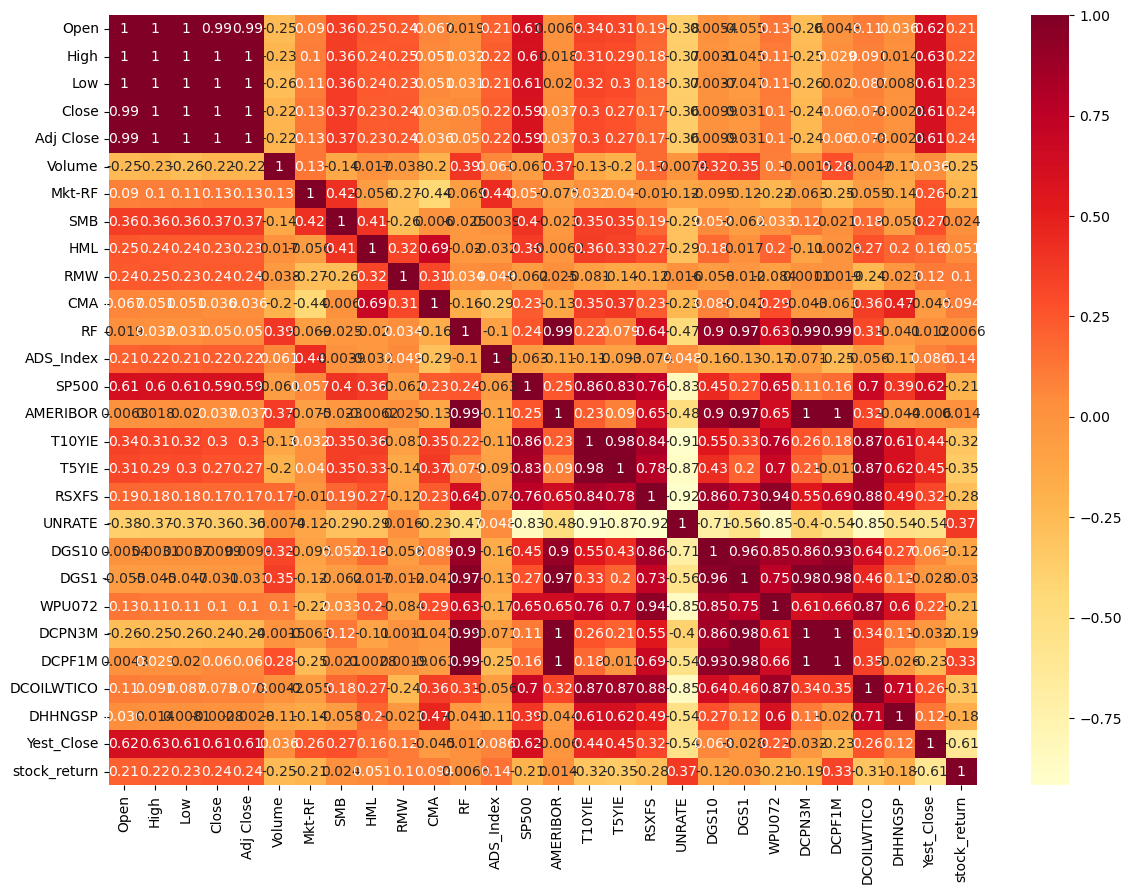

In [36]:
x = LULU_new.iloc[1:, 1:]
y = LULU_new.iloc[:, -2]
corrmat = LULU_new.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (14,10))
hm = sns.heatmap(LULU_new[top_corr_features].corr(), annot = True, cmap = "YlOrRd")

In [37]:
X = LULU_new[['Mkt-RF', 'SMB', 'HML', 'ADS_Index']]/100
y = LULU_new['stock_return'] - LULU_new['RF']
X = sm.add_constant(X)

ff_model = sm.OLS(y, X).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.137
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.362
Time:                        18:27:51   Log-Likelihood:                 16.513
No. Observations:                  30   AIC:                            -23.03
Df Residuals:                      25   BIC:                            -16.02
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0306      0.031      1.001      0.3

In [38]:
X

,const,Mkt-RF,SMB,HML,ADS_Index
1,1.0,-0.0291,-0.0090,-0.0097,-0.109825
2,1.0,0.0052,0.0026,0.0043,0.089921
3,1.0,0.0041,-0.0171,-0.0258,0.074320
4,1.0,0.0092,0.0019,-0.0030,0.020396
5,1.0,0.0079,0.0079,-0.0054,0.010812
6,1.0,0.0098,-0.0008,0.0053,-0.001054
7,1.0,0.0173,0.0074,-0.0147,-0.007167
8,1.0,0.0263,0.0111,0.0023,0.000524
9,1.0,0.0127,0.0021,0.0000,0.016348
10,1.0,0.0003,0.0141,0.0146,0.003245


In [39]:
y

1     0.191771
2     0.411541
3    -0.001227
4     0.267449
5    -0.128106
6     0.106934
7    -0.116683
8    -0.055897
9    -0.043706
10    0.058292
11    0.143149
12    0.085935
13    0.014765
14    0.143284
15   -0.022773
16   -0.230850
17   -0.086196
18    0.164810
19   -0.213864
20   -0.095668
21    0.169045
22   -0.059192
23    0.107956
24    0.139770
25   -0.191144
26   -0.035702
27    0.227950
28   -0.166121
29    0.140987
30    0.039282
dtype: float64

In [40]:
ff_model.params

const        0.030636
Mkt-RF      -6.790223
SMB          5.344168
HML         -1.110285
ADS_Index    1.787545
dtype: float64

In [41]:
LULU_new.to_csv('INFOP7374_FeatureMart4GS.csv', index=True)